Author: <b>Reinaldo Maciel</b> <br>
Date: June, 2nd 2020 <br><br>


The study below will show us that in order to predict if a given customer is going to be Charged Off or Full pay of your loan, you have to do a good job on featuring engineering.
The given data has information related to 403k loans with more than 150 variables.
Many information was correlated for the numerical variables which from the help of PCA decrease the total of 111 numerical variables to 10 principal components. I choose using ensemble techniquest to predict, since it empowers the single classifier.
The prediction itself showed that Randon Forest and a Prunned Decision tree have the best performance, with both showing that the variables that are more relevant to identify those who are going to be Charged Off the following:
- last_credit_pull_d;
- grade;
- debt_settlement_flag;
- term;
- And the 10 principal components created, which have no pratical interpretation;


The final model - Random Forest - has an <b>accuraccy of 90%</b> on test data for october, november and december 2016, and an <b>AUC of 0.79</b>.

In [1]:
##importing libraries


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as ss

from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics


In [2]:
##importing raw data
df1 = pd.read_csv('LoanStats_securev1_2016Q1.csv', low_memory=False)
df2 = pd.read_csv('LoanStats_securev1_2016Q2.csv', low_memory=False)
df3 = pd.read_csv('LoanStats_securev1_2016Q3.csv', low_memory=False)
df4 = pd.read_csv('LoanStats_securev1_2016Q4.csv', low_memory=False)

## appending data
df_loans = df1.append(df2.append(df3.append(df4)))

## freeing memory
raw_dfs = [df1, df2, df3, df4]
del raw_dfs

In [3]:
### verifying appended data
df_loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,73438990,NaN,12500,12500,12500.0,60 months,7.39%,249.83,A,A4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,74694337,NaN,40000,40000,40000.0,60 months,7.89%,808.96,A,A5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,74716491,NaN,20000,20000,20000.0,36 months,9.75%,643.00,B,B3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,74826201,NaN,7200,7200,7200.0,36 months,5.32%,216.83,A,A1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,74884818,NaN,32000,32000,32000.0,36 months,6.97%,987.63,A,A3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


## How Many Loans are they? 

Before go to the assuption that we have one row in the data frame for each loan, let`s check if there is no duplicated id for this.

In [4]:
df_loans['id'].is_unique

True

<font color='blue'>Total of Loans:</font>

In [5]:
len(df_loans['id'].values)

434407

## How many columns does the dataset have? 

<font color='blue'>Total of columns:</font>

In [6]:
df_loans.shape[1]

150

## How many columns only contains misssing data?

<font color='blue'> Total of columns with only missing data: </font>

In [7]:
len(df_loans.columns[df_loans.isnull().sum() == len(df_loans['id'].values)])

14

## How many loans are still current?

<font color='blue'> Total of loans with "Current" status:</font>

In [8]:
df_loans[df_loans['loan_status'] == 'Current'].shape[0]

30120

Subset the dataset to only have Fully paid and Charged Off loans. We won’t need the others from here on.

In [9]:
df_loans_work_data = df_loans[(df_loans['loan_status'] == 'Fully Paid') | (df_loans['loan_status']=='Charged Off')]

In [10]:
##checking if data has been correctly filtered
df_loans_work_data['loan_status'].unique()

array(['Charged Off', 'Fully Paid'], dtype=object)

### Is that an inbalanced dataset?

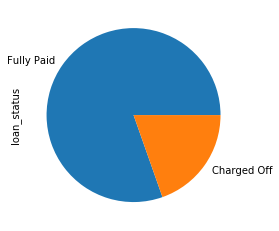

In [11]:
ax = df_loans_work_data['loan_status'].value_counts().plot(kind='pie')

The target variable has a good balance between the expected classes.

### Getting rid of ids

In [12]:
df_loans_work_data = df_loans_work_data.drop(columns=['id','member_id'])

### Converting Interest Rate to numerical

In [13]:
df_loans_work_data['int_rate'] = df_loans_work_data['int_rate'].str.replace('%','').str.replace(' ','').astype(dtype=np.float64)

### Checking for Correlation between numerical data (Only top 30)

In [14]:
high_correlation = (df_loans_work_data._get_numeric_data().corr()>0.70).sum().sort_values(ascending=False)
top_30_high_correlation = high_correlation[0:29]

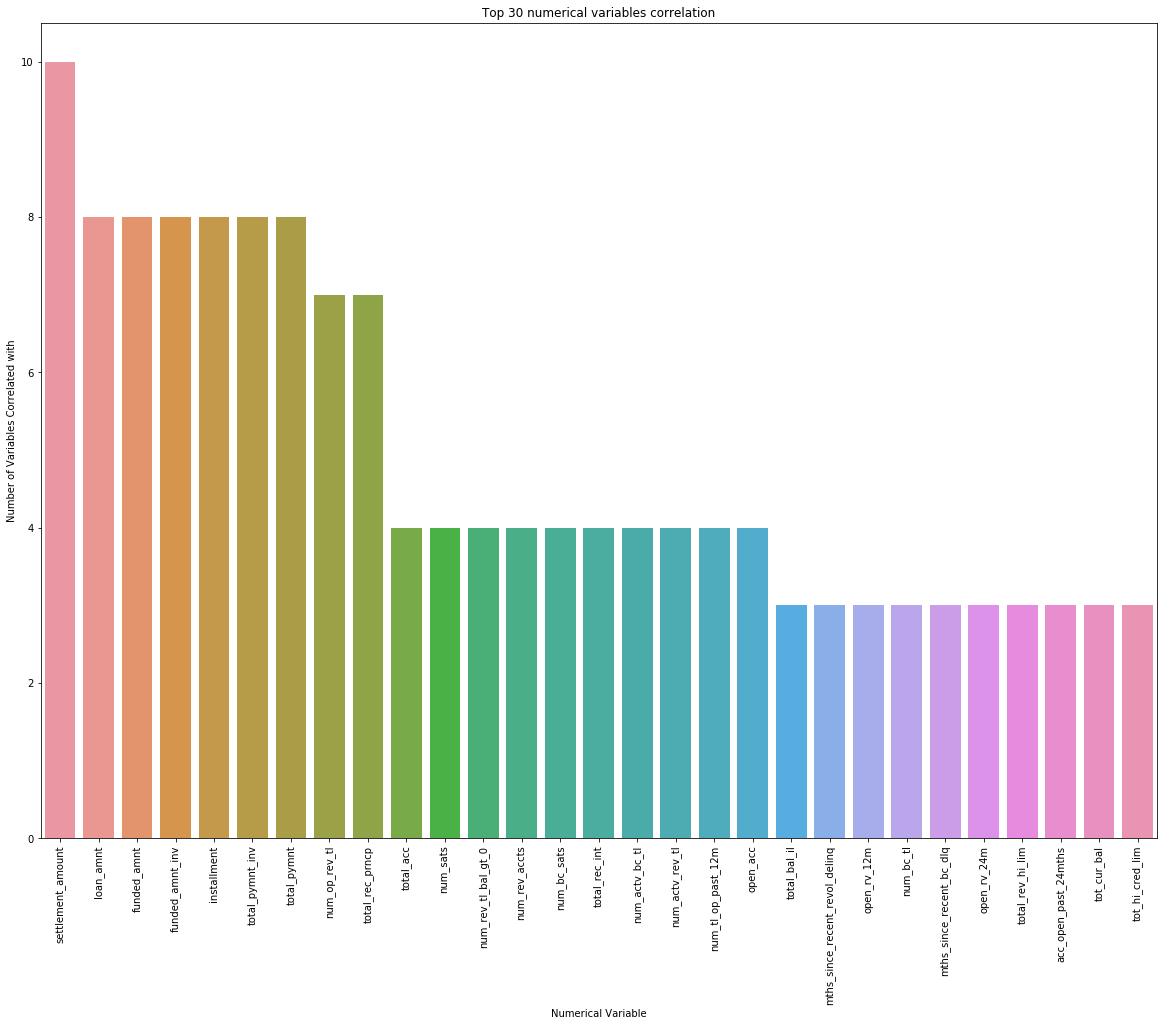

In [15]:
fig, ax = plt.subplots(figsize=(20,15))
plt.title('Top 30 numerical variables correlation')
plt.xlabel('Numerical Variable')
plt.ylabel('Number of Variables Correlated with')
ax = sns.barplot(ax = ax, x=top_30_high_correlation.index, y=top_30_high_correlation.values)
ax = ax.set_xticklabels(labels = top_30_high_correlation.index, rotation=90)

That`s a good clue that we`re not going to need the whole numerical for our model.

### Verifying numerical data against our target variable

The main goal here is finding what are the numerical variables that has the most different means for clients who were charged off against Fully Paid. To be fair, we`re going to use zscore as a measure.

/Users/reinaldodeoliveiramaciel/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


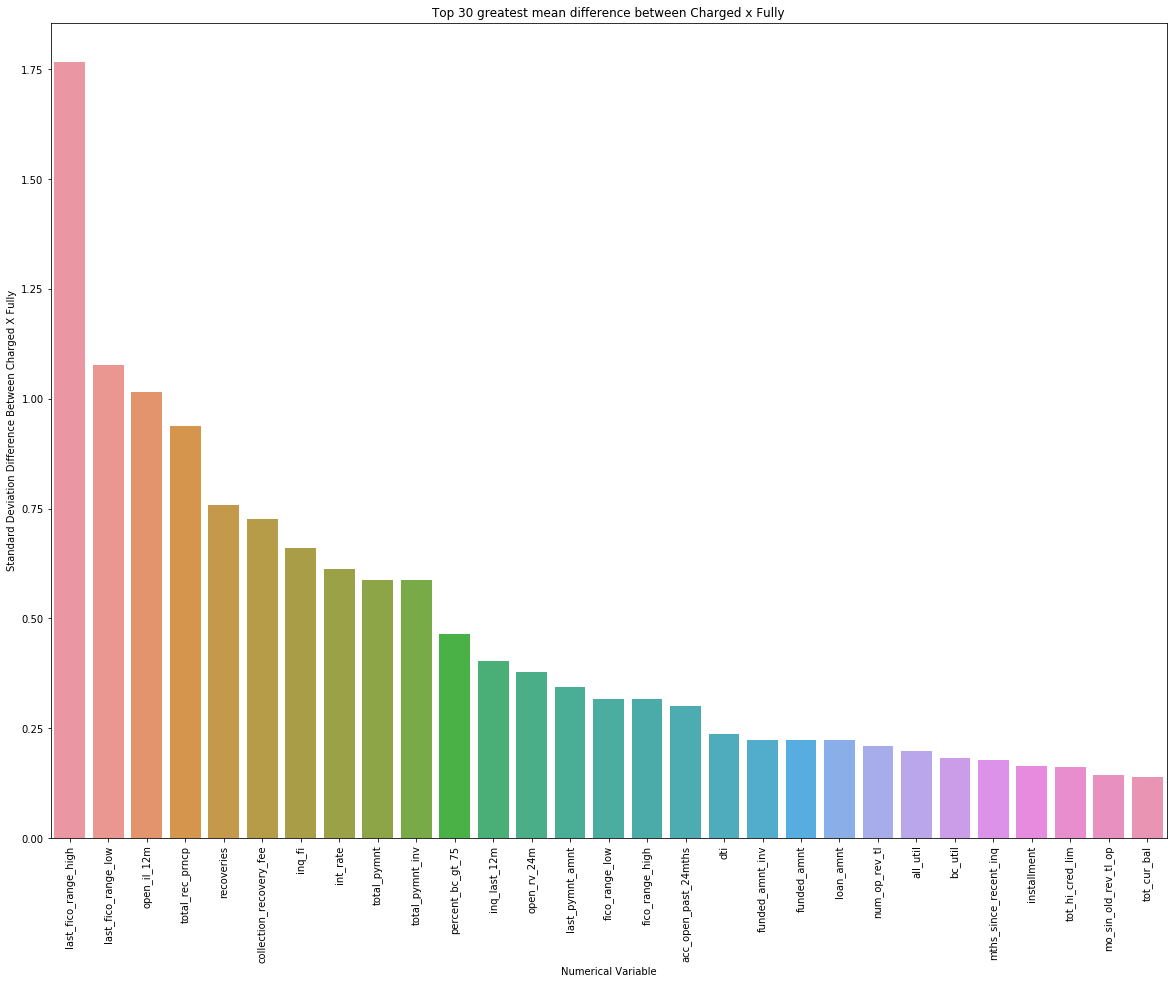

In [16]:
df_loans_numeric_only = df_loans_work_data._get_numeric_data()
numcols = df_loans_numeric_only.columns
df_loans_numeric_only = df_loans_numeric_only.replace([np.inf, -np.inf], np.nan)
df_loans_numeric_only_std = df_loans_numeric_only.fillna(df_loans_numeric_only.mean())
df_loans_numeric_only_std = df_loans_numeric_only_std.apply(zscore)
df_loans_numeric_only_std['target'] = df_loans_work_data.loan_status

mean_diffs = df_loans_numeric_only_std.groupby('target').median().T
mean_diffs['differences'] = abs(mean_diffs['Charged Off'] - mean_diffs['Fully Paid'])
highest_means_diff = mean_diffs['differences'].sort_values(ascending=False)
top_30_high_mean_differences = highest_means_diff[0:29]

fig, ax = plt.subplots(figsize=(20,15))
plt.title('Top 30 greatest mean difference between Charged x Fully')
plt.xlabel('Numerical Variable')
plt.ylabel('Standard Deviation Difference Between Charged X Fully')
ax = sns.barplot(ax = ax, x=top_30_high_mean_differences.index, y=top_30_high_mean_differences.values)
ax = ax.set_xticklabels(labels = top_30_high_mean_differences.index, rotation=90)

So far, I`m sure that there is a bunch of numerical variables that are useless to try to predict our target data.

Every variable with high correlation with another one can be joined.

Every variable with a difference of less than 0.25 standard deviation can be joined to others also.

### Proceeding with PCA

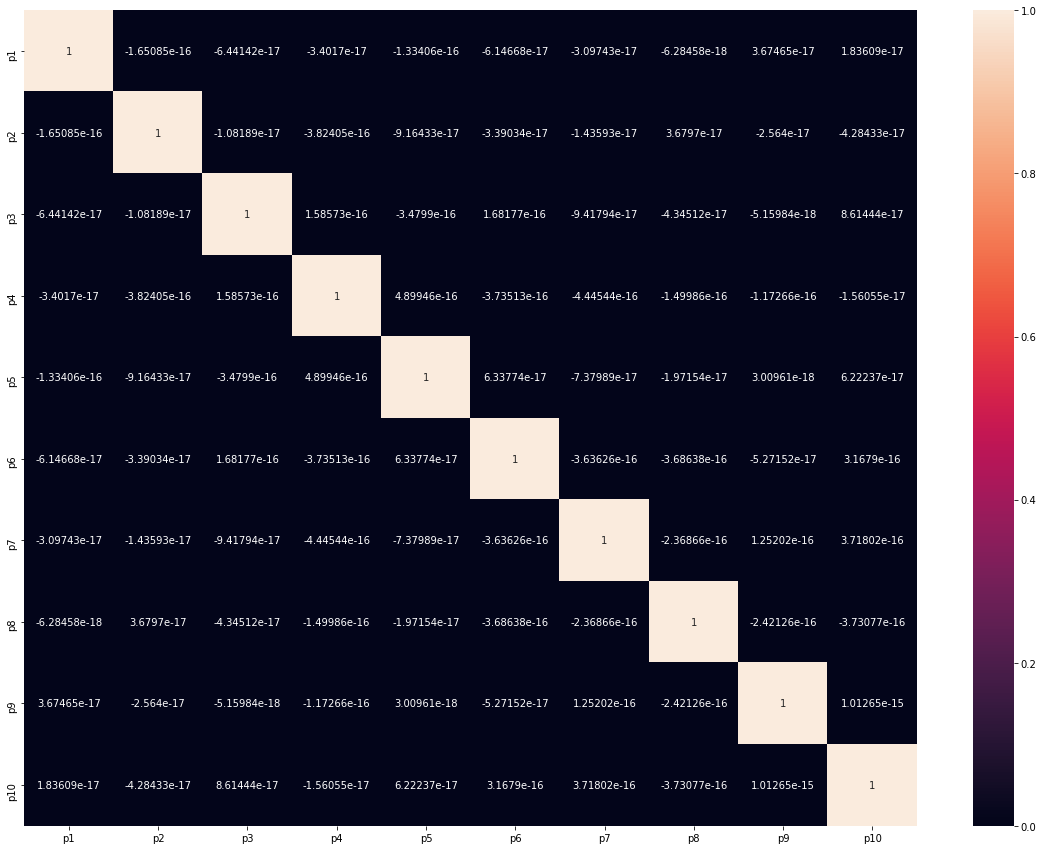

In [17]:
pca = PCA(n_components=10)

df_loans_numeric_only_std.drop(columns= df_loans_numeric_only_std.columns[df_loans_numeric_only_std.isnull().sum()>1], 
                               inplace=True)
df_loans_numeric_only_pca = df_loans_numeric_only_std.drop('target', axis=1)

principalComponents = pca.fit_transform(df_loans_numeric_only_pca)

pcaDF = pd.DataFrame(data=principalComponents, columns=['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10'])
fig, ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(pcaDF.corr(), annot=True, fmt='g')


Now I end up with only 10 numerical variables that have almost no correlation between themselves and have a lot of information related to the inicial variables.

### Understanding categorical variables

For every categorical variable lets evaluate it`s correlation with the target variable using <b> Crammer's V </b> correlation.

In [18]:
cat_columns = df_loans_work_data.select_dtypes(include='object').drop('loan_status', axis=1).columns

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [19]:
df_categorical_correlations = pd.DataFrame(columns=['X','Y','value'])
for cat_variable in cat_columns:
    try:
        df_categorical_correlations.loc[len(df_categorical_correlations)] = [cat_variable,'loan_status',
                                            cramers_v(df_loans_work_data[cat_variable],df_loans_work_data['loan_status'])]
    except:
        pass

/Users/reinaldodeoliveiramaciel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


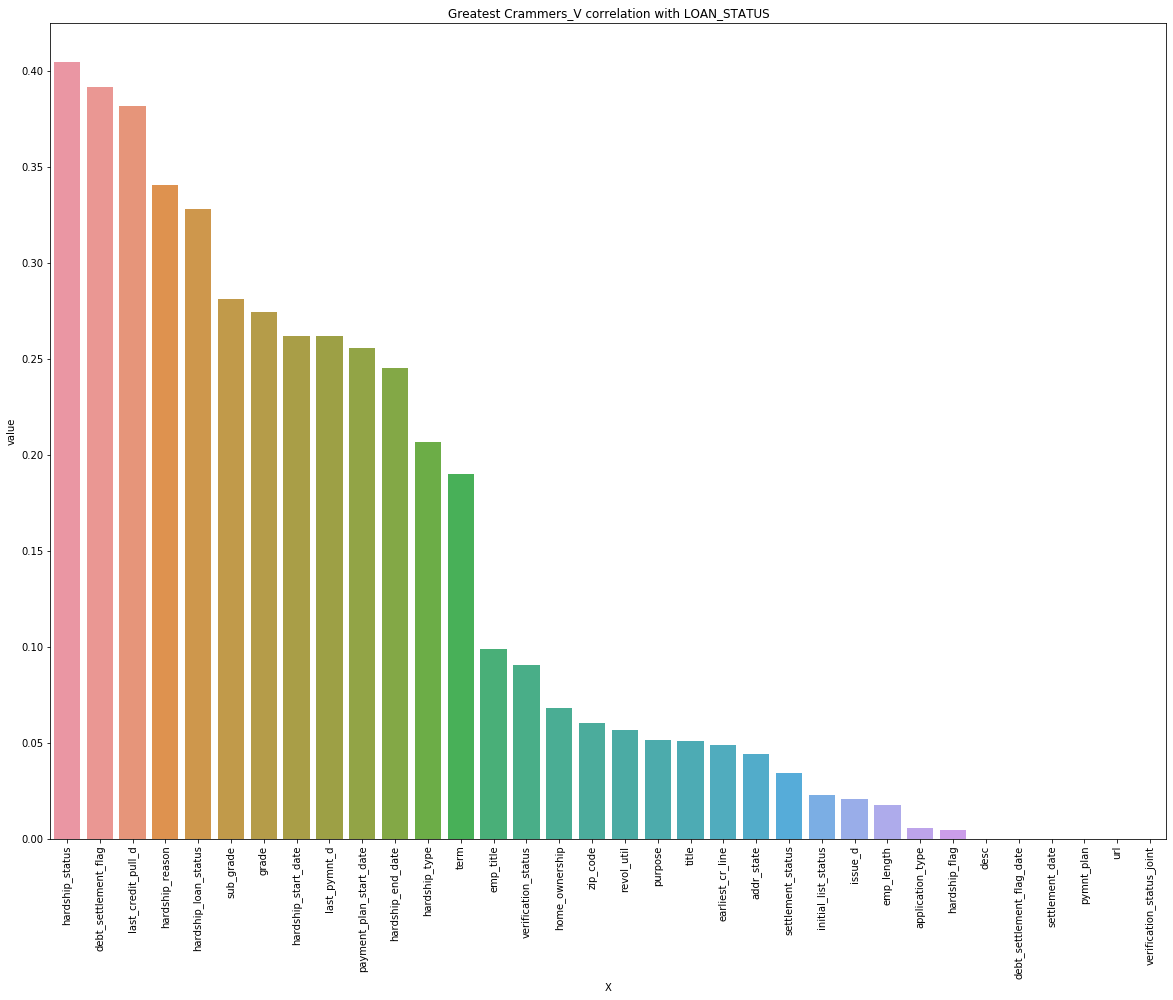

In [20]:
df_categorical_correlations.sort_values(by=['value'], ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(20,15))
plt.title('Greatest Crammers_V correlation with LOAN_STATUS')
plt.xlabel('Crammers_V value')
plt.ylabel('Categorical Variable')
ax = sns.barplot(ax = ax, x=df_categorical_correlations['X'], y=df_categorical_correlations['value'])
ax = ax.set_xticklabels(labels = df_categorical_correlations['X'], rotation=90)

It`s also clear that we have categorical variables that are not contributing with LOAN_STATUS since they are null values or very sparse data (like desc variable)

### Keeping only usefull cat data (by crammers_v correlation GT 0.10)

In [21]:
keep_cat_data = list(df_categorical_correlations[df_categorical_correlations['value']>0.10]['X'].values)
df_cat_data = df_loans_work_data[keep_cat_data]

### Filling up NAN data with a flag of missing

In [22]:
df_cat_data = df_cat_data.fillna('Missing')

### One Hot Encoding

In [23]:
df_cat_data_dummies = pd.get_dummies(df_cat_data)
df_cat_data_dummies['target'] = df_loans_work_data.loan_status
df_cat_data_dummies['issue_d'] = df_loans_work_data.issue_d
df_cat_data_dummies.head()

,hardship_status_ACTIVE,hardship_status_BROKEN,hardship_status_COMPLETE,hardship_status_COMPLETED,hardship_status_Missing,debt_settlement_flag_N,debt_settlement_flag_Y,last_credit_pull_d_Apr-2016,last_credit_pull_d_Apr-2017,last_credit_pull_d_Apr-2018,...,hardship_end_date_Sep-2018,hardship_end_date_Sep-2019,hardship_type_CVD19SKIP,hardship_type_INTEREST ONLY-3 MONTHS DEFERRAL,hardship_type_Missing,hardship_type_ST0650PV01,term_ 36 months,term_ 60 months,target,issue_d
0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,1,Charged Off,Mar-2016
2,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,Fully Paid,Mar-2016
3,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,Fully Paid,Mar-2016
4,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,Fully Paid,Mar-2016
6,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,Fully Paid,Mar-2016


### Joining Numerical and Categorical Data

In [24]:
df_data_cleaned = pd.merge(pcaDF, df_cat_data_dummies,how='inner', left_index=True, right_index=True)

### Split data into train x test

In [25]:
train_lst = ['Jan-2016','Feb-2016','Mar-2016','Apr-2016','May-2016','Jun-2016','Jul-2016','Aug-2016','Sep-2016']
test_lst = ['Oct-2016','Nov-2016','Dec-2016']


df_train = df_data_cleaned[df_data_cleaned['issue_d'].isin(train_lst)]
df_test = df_data_cleaned[df_data_cleaned['issue_d'].isin(test_lst)]

In [26]:
df_train.drop(columns=['issue_d'], inplace=True)
df_test.drop(columns=['issue_d'], inplace=True)

/Users/reinaldodeoliveiramaciel/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
X_train = df_train.drop(columns=['target']).values
Y_train = df_train['target'].values

X_test = df_test.drop(columns=['target']).values
Y_test = df_test['target'].values

### Model Build - RAW DECISION TREE

In [28]:
### Decision Tree Model

clf = DecisionTreeClassifier(random_state=1)
clf.fit(X_train,Y_train)

print('Accuracy on Train Set:', clf.score(X_train, Y_train))
print('Accuracy on Test Set:', clf.score(X_test, Y_test))

Accuracy on Train Set: 1.0
Accuracy on Test Set: 0.8563300887459268


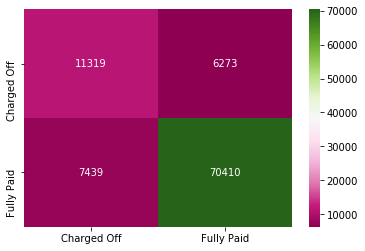

In [29]:
y_predict = clf.predict(X_test)
cm = pd.DataFrame(metrics.confusion_matrix(Y_test, y_predict), columns=['Charged Off','Fully Paid'], 
                  index=['Charged Off','Fully Paid'])
ax = sns.heatmap(cm, fmt='d', cmap='PiYG', annot=True)

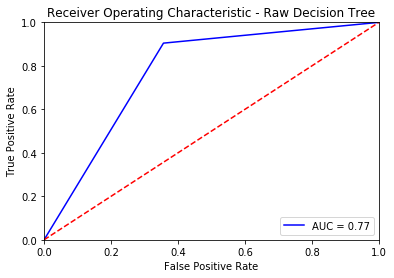

In [30]:
k = {'Charged Off':0, 'Fully Paid':1}

fpr, tpr, threshold = metrics.roc_curve([k[y] for y in Y_test], [k[y1] for y1 in y_predict])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic - Raw Decision Tree')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


<font color='blue'> This model has a good performance on the test set (85%), but it can generalize better on unseen data since its overfitting.  </font>

### Model Build - Prunned Decision Tree

In [31]:
### Decision Tree Model

clf = DecisionTreeClassifier(random_state=1, max_depth=20)
clf.fit(X_train,Y_train)

print('Accuracy on Train Set:', clf.score(X_train, Y_train))
print('Accuracy on Test Set:', clf.score(X_test, Y_test))

Accuracy on Train Set: 0.8953773029770051
Accuracy on Test Set: 0.8756614033800987


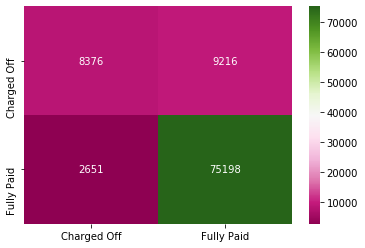

In [32]:
y_predict = clf.predict(X_test)
cm = pd.DataFrame(metrics.confusion_matrix(Y_test, y_predict), columns=['Charged Off','Fully Paid'], 
                  index=['Charged Off','Fully Paid'])
ax = sns.heatmap(cm, fmt='d', cmap='PiYG', annot=True)

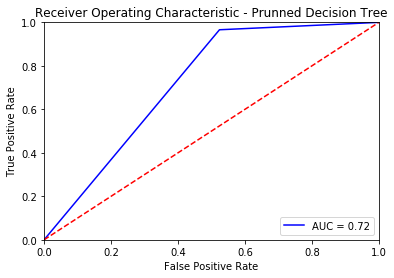

In [33]:
k = {'Charged Off':0, 'Fully Paid':1}

fpr, tpr, threshold = metrics.roc_curve([k[y] for y in Y_test], [k[y1] for y1 in y_predict])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic - Prunned Decision Tree')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<font color='blue'> This model has no more problem with overffiting, it`s performance is even a little better than raw decision tree. But it's AUC now is 72% against 77% for raw tree. It means that this model has some difficult to find who is really going to be Charged Off. </font>

### Model Build - Gradient Boosting

In [34]:
gbcl = GradientBoostingClassifier(n_estimators = 50,random_state=1)
gbcl = gbcl.fit(X_train, Y_train)

print('Accuracy on Train Set:', gbcl.score(X_train, Y_train))
print('Accuracy on Test Set:', gbcl.score(X_test, Y_test))

Accuracy on Train Set: 0.8563937176315302
Accuracy on Test Set: 0.8630462799006716


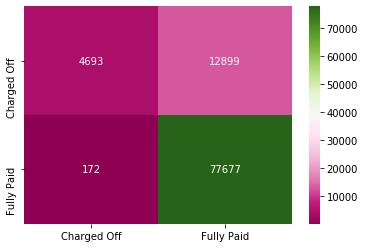

In [35]:
y_predict = gbcl.predict(X_test)
cm = pd.DataFrame(metrics.confusion_matrix(Y_test, y_predict), columns=['Charged Off','Fully Paid'], 
                  index=['Charged Off','Fully Paid'])
ax = sns.heatmap(cm, fmt='d', cmap='PiYG', annot=True)

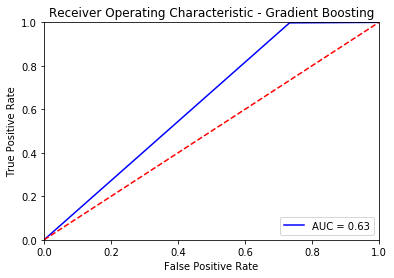

In [36]:
k = {'Charged Off':0, 'Fully Paid':1}

fpr, tpr, threshold = metrics.roc_curve([k[y] for y in Y_test], [k[y1] for y1 in y_predict])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic - Gradient Boosting')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<font color='blue'>Gradient Boosting has the poorest performance of all models evaluated so far: it has the lowest AUC indicating that this model doesnt have a good balance between errors on Fully Paid and Charged Off.</font>

### Model Build - Random Forest

In [37]:
rfcl = RandomForestClassifier(n_estimators = 50, random_state=1, max_features=40)
rfcl = rfcl.fit(X_train, Y_train)

print('Accuracy on Train Set:', rfcl.score(X_train, Y_train))
print('Accuracy on Test Set:', rfcl.score(X_test, Y_test))

Accuracy on Train Set: 0.999752918648465
Accuracy on Test Set: 0.9062876541528274


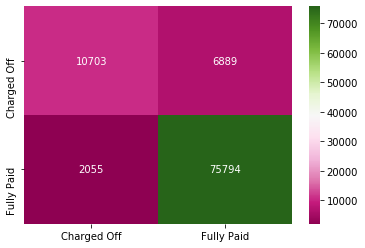

In [38]:
y_predict = rfcl.predict(X_test)
cm = pd.DataFrame(metrics.confusion_matrix(Y_test, y_predict), columns=['Charged Off','Fully Paid'], 
                  index=['Charged Off','Fully Paid'])
ax = sns.heatmap(cm, fmt='d', cmap='PiYG', annot=True)

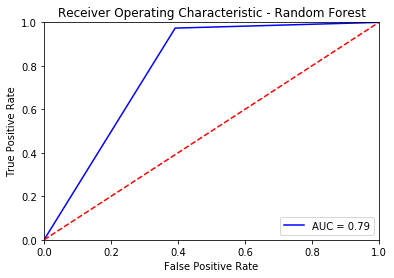

In [39]:
k = {'Charged Off':0, 'Fully Paid':1}

fpr, tpr, threshold = metrics.roc_curve([k[y] for y in Y_test], [k[y1] for y1 in y_predict])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<font color='blue'> Random Forest shows a good performance on accuraccy but only has an improvement of 3% on prunned decision tree accuracy keeping the same AUC. </font>

### Feature Importance

In [56]:
### feature importance for Randon Forest
df_train.drop(columns=['target']).columns[rfcl.feature_importances_>0.01]

Index(['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10',
       'debt_settlement_flag_N', 'debt_settlement_flag_Y',
       'last_credit_pull_d_Jul-2018', 'last_credit_pull_d_May-2020', 'grade_A',
       'term_ 36 months', 'term_ 60 months'],
      dtype='object')

In [49]:
### feature importance for Decisionn Tree
df_train.drop(columns=['target']).columns[clf.feature_importances_>0.01]

Index(['p1', 'p3', 'p5', 'debt_settlement_flag_Y',
       'last_credit_pull_d_Feb-2017', 'last_credit_pull_d_Jul-2017',
       'last_credit_pull_d_Jul-2018', 'last_credit_pull_d_Jun-2017',
       'last_credit_pull_d_May-2020', 'last_credit_pull_d_Nov-2017',
       'last_credit_pull_d_Oct-2017', 'grade_A', 'grade_B',
       'last_pymnt_d_Aug-2017', 'last_pymnt_d_Jul-2017',
       'last_pymnt_d_Jun-2017', 'last_pymnt_d_Mar-2017',
       'last_pymnt_d_May-2017', 'last_pymnt_d_Sep-2017', 'term_ 60 months'],
      dtype='object')

In [57]:
pass